In [103]:
%load_ext autoreload
%autoreload 2

import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import v2
from lib.utils.config import load_config
from lib.data.metainfo import MetaInfo
import hydra
import glob
import cv2
import tqdm

from lib.utils.config import load_config
from lib.data.metainfo import MetaInfo
from lib.data.transforms import SketchTransform

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Settings and Folders

In [104]:
# capture all .mov videos in raw_video directory
demo_folder = "/home/korth/sketch2shape/demo_video"
video_name = "five"
video_paths = glob.glob(f"{demo_folder}/input_videos/{video_name}*")
frames_folder = f"{demo_folder}/video_frames"


# create folders if they do not exist
if not os.path.exists(frames_folder):
    os.makedirs(frames_folder)

# Extract Frames from Raw Video

In [100]:
frames = []

num_frames_to_extract = 150  # Set the number of frames to extract
for video_file in video_paths:
    # Open the video file
    video = cv2.VideoCapture(video_file)
    
    # Get the total number of frames in the video
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate the frame interval
    frame_interval = max(total_frames // num_frames_to_extract, 1)
    
    # Read frames at the specified interval
    frame_count = 0
    while video.isOpened() and frame_count < total_frames:
        # Read the current frame
        ret, frame = video.read()
        
        # If the frame was read successfully
        if ret:
            # Add the frame to the list of frames
            if frame_count % frame_interval == 0:
                frames.append(frame)
            frame_count += 1
        else:
            # Break the loop if the video is completed
            break
    
    # Release the video file
    video.release()

print(f"Extracted {len(frames)} frames from {len(video_files)} videos")

folder = f"{frames_folder}/{video_name}"
# create folder if it does not exist (in python)
os.makedirs(frames_folder, exist_ok=True)
os.makedirs(folder, exist_ok=True)


# save the frames to disk
for i, frame in enumerate(frames):
    cv2.imwrite(f"{folder}/frame_{i:03}.png", frame)

print(f"Saved {len(frames)} frames to disk at '{folder}'")

Extracted 165 frames from 1 videos
Saved 165 frames to disk at '/home/korth/sketch2shape/demo_video/video_frames/five'


# Load Models

In [107]:
print(cfg.model)

{'_target_': 'lib.optimizer.sketch.SketchOptimizer', 'data_dir': '${data.data_dir}', 'loss_ckpt_path': '/home/borth/sketch2shape/checkpoints/latent_siamese_sketch_grayscale_multi_view_256.ckpt', 'deepsdf_ckpt_path': '${deepsdf_ckpt_path}', 'optimizer': {'_target_': 'torch.optim.Adam', '_partial_': True, 'lr': 0.01}, 'scheduler': None, 'latent_init': 'latent', 'reg_loss': 'none', 'reg_weight': 0.002, 'prior_obj_id': '', 'prior_view_id': 11, 'retrieval_k': 16, 'mesh_resolution': 128, 'mesh_chunk_size': 65536, 'n_render_steps': 100, 'clamp_sdf': 0.1, 'step_scale': 1.0, 'surface_eps': 0.001, 'sphere_eps': 0.1, 'normal_eps': 0.005, 'log_images': True, 'capture_rate': 8, 'loss_weight': 1.0, 'silhouette_loss': 'none', 'silhouette_weight': 1.0}


In [108]:
cfg = load_config("optimize_sketch", ["dataset=shapenet_chair_single_view_4096"])
metainfo = MetaInfo(cfg.data.data_dir)

cfg.model.prior_obj_id = metainfo.obj_ids[4015]
# cfg.model.loss_ckpt_path = "/home/borth/sketch2shape/checkpoints/old/latent_siamese_sketch_grayscale_latent_256.ckpt"
cfg.model.retrieval_k = 4

cfg.model.loss_ckpt_path = "/home/borth/sketch2shape/checkpoints/latent_siamese_sketch_grayscale_multi_view_256.ckpt"
cfg.model.latent_init = "latent"

model = hydra.utils.instantiate(cfg.model).to("cuda")

model.deepsdf.create_camera()

/home/korth/miniconda3/envs/sketch2shape/lib/python3.11/site-packages/lightning/pytorch/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.2.0.post0, which is newer than your current Lightning version: v2.1.3
/home/korth/miniconda3/envs/sketch2shape/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [109]:
# transform = v2.Compose([
#     v2.ToTensor(),
#     v2.Resize((256, 256)),
    
#     # v2.CenterCrop(256),
#     v2.Normalize(mean=[0.5], std=[0.5])
# ])
transform = SketchTransform()

def load_handrawn(img_path):
    # load img, convert to torch tensor and resize to 256x256
    img1 = plt.imread(img_path)
    img1 = img1 / 255.0

    return transform(img1).to(torch.float32)

def load_sketch(img_path):
    # load img, convert to torch tensor and resize to 256x256
    img1 = plt.imread(img_path)
    return transform(img1).to(torch.float32)

In [110]:
# Process each frame and extract normals by rendering the latents
visualize = False

original_images = []
normal_images = []

for path in tqdm.tqdm(sorted(glob.glob(frames_folder + "/" + video_name + "/*.png"))):
    if "handrawn" in path:
        img = load_handrawn(path)
    else:
        img = load_sketch(path)
    with torch.no_grad():
        latent = model.loss(img.unsqueeze(0).cuda())
        normals = model.deepsdf.capture_camera_frame(latent.squeeze())
    
    # Save original and normal images into separate lists
    original_images.append(plt.imread(path))
    normal_images.append(normals.cpu().numpy())
    
    if visualize:
        # Print original image, preprocessed image, and normals
        plt.figure()
        plt.subplot(1, 3, 1)
        plt.title("Original")
        plt.imshow(plt.imread(path))
        plt.axis("off")
        
        plt.subplot(1, 3, 2)
        plt.title("Preprocessed")
        plt.imshow(img.cpu().numpy().transpose(1, 2, 0))
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.title("Normals")
        plt.imshow(normals.cpu().numpy())
        plt.axis("off")

        plt.show()

  0%|          | 0/165 [00:00<?, ?it/s]

100%|██████████| 165/165 [05:15<00:00,  1.91s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


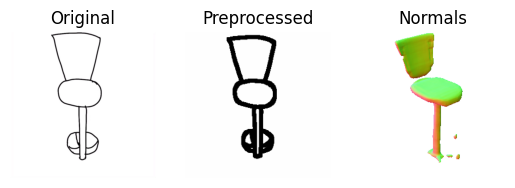

In [111]:
# visualize for sanity check
plt.figure()
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(plt.imread(path))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Preprocessed")
plt.imshow(img.cpu().numpy().transpose(1, 2, 0))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Normals")
plt.imshow(normals.cpu().numpy())
plt.axis("off")

plt.show()

# Individual Videos

In [112]:
import cv2

# if output_videos folder does not exist, make it
if not os.path.exists(f"{demo_folder}/output_videos"):
    os.makedirs(f"{demo_folder}/output_videos")

# Define the output video filenames
original_video_filename = f"{demo_folder}/output_videos/{video_name}_original_video.mp4"
normal_video_filename = f"{demo_folder}/output_videos/{video_name}_normal_video.mp4"

# Define the video codec and frame rate
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
fps = 10

res_original = original_images[0].shape[0]

# Create the video writers
original_video_writer = cv2.VideoWriter(original_video_filename, fourcc, fps, (res_original, res_original))
normal_video_writer = cv2.VideoWriter(normal_video_filename, fourcc, fps, (256, 256))

# Write the frames to the videos
for idx, frame in enumerate(original_images):
    original_video_writer.write((frame*255).astype(np.uint8))

for frame in normal_images:
    normal_video_writer.write((frame*255).astype(np.uint8))

# Release the video writers
original_video_writer.release()
normal_video_writer.release()

print("Videos created successfully.")


Videos created successfully.


# Side by Side Video

In [113]:
# Define the output video filename
side_by_side_video_filename = f"{demo_folder}/output_videos/{video_name}_side_by_side_video.mp4"

# Create the video writer
side_by_side_video_writer = cv2.VideoWriter(side_by_side_video_filename, fourcc, 5, (392, 196))

# Write the frames to the video
for idx, (original_frame, normal_frame) in enumerate(zip(original_images, normal_images)):
    # Resize the frames to have the same height
    original_frame_resized = cv2.resize(original_frame, (196, 196))
    normal_frame_resized = cv2.resize(normal_frame, (196, 196))
    
    # Concatenate the frames side by side
    side_by_side_frame = cv2.hconcat([original_frame_resized, normal_frame_resized])
    
    # Write the side by side frame to the video
    side_by_side_video_writer.write((side_by_side_frame*255).astype(np.uint8))

# Release the video writer
side_by_side_video_writer.release()

print("Side by side video created successfully.")


Side by side video created successfully.
